In [3]:
import pandas as pd
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import numpy as np
from functools import lru_cache
from nltk.corpus import stopwords
import nltk

In [4]:
MIN_LENGTH = 500

In [5]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def propagate_str_value_forward(df, min_length=MIN_LENGTH):
    df = df.copy()
    # Replace empty strings with NaN
    df.replace('', np.nan, inplace=True)  
    # Replace strings with length less than min_length with NaN
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(lambda x: np.nan if isinstance(x, str) and len(x) < min_length else x)
    # Forward fill NaN values
    df = df.T.ffill(axis=0).T  
    # Fill remaining NaN with empty strings
    df.fillna('', inplace=True)  
    return df

def remove_stopwords(text):
    if isinstance(text, str):
        return ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

website_df = pd.read_csv("website_data.csv")
website_metadata_csv = pd.read_csv("all_MIU_firms_location_sectors_products_cleaned.csv", encoding="latin1")
website_metadata_csv = website_metadata_csv[["company_name", "sector_long"]]
website_df = website_df.merge(website_metadata_csv, left_on="company_name", right_on="company_name", how="left")
category_column = website_df["sector_long"]

selected_cols = reversed([col for col in website_df.columns if col.startswith("1") or col.startswith("2")])
website_df = website_df[selected_cols]
website_df = propagate_str_value_forward(website_df)

for col in tqdm(website_df.select_dtypes(include=['object']).columns):
    website_df[col] = website_df[col].apply(remove_stopwords)

website_df["category"] = category_column

[nltk_data] Downloading package stopwords to /Users/vijay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_85419/1489080438.py:23: DtypeWarning: Columns (300,304,325,328) have mixed types. Specify dtype option on import or set low_memory=False.
  website_df = pd.read_csv("website_data.csv")
/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_85419/1489080438.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.T.ffill(axis=0).T
100%|██████████| 325/325 [00:46<00:00,  6.97it/s]
/var/folders/rw/s7c9z30x7fj_2gcngv0yhv6w0000gn/T/ipykernel_85419/1489080438.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [6]:
joined_series = website_df.astype(str).apply(lambda col: ' '.join(col))


In [7]:
# convert joined_series to one-row df
joined_df = pd.DataFrame(columns=website_df.columns, data=[list(joined_series)])

In [8]:
REMOVE_KEYWORDS = True
removal_keywords = ["credit card", "air force"]


In [9]:
category_counts = website_df["category"].value_counts()
category_counts = category_counts[category_counts >= 30]
print(category_counts)
important_categories = category_counts.index.tolist()

category
Travel, Personal & Leisure TPL                      250
Textiles & Clothing Manufacturing TCM               173
Metals & Metal Products MMP                         143
Wood, Furniture & Paper Manufacturing WFPM          129
Food & Tobacco Manufacturing FTM                    127
Transport Manufacturing TM                          102
Miscellaneous Manufacturing MM                       65
Industrial, Electric & Electronic Machinery IEEM     64
Utilities U                                          30
Name: count, dtype: int64


In [10]:
session_year_map = {2007: 110, 2008: 110, 2009: 111, 2010: 111, 2011: 112, 2012: 112, 2013: 113, 2014: 113, 2015: 114, 2016: 114, 2017: 115, 2018: 115, 2019: 116, 2020: 116}
all_website_scores = []
default_scores = []
global_explanation = ""

all_website_scores_by_categories = []

for year in session_year_map:
    global_explanation += f"-------------------\n--------------------\nYear: {year}\n"
    session = session_year_map[year]
    keywords_df = pd.read_csv(f"Partisan Index/{session}_congress_alpha_beta.csv") 
    if REMOVE_KEYWORDS:
        keywords_df = keywords_df[~keywords_df["phrase_clean"].isin(removal_keywords)]

    valid_columns = [col for col in website_df.columns if str(year) in col]
    last_month_column = valid_columns[-1]

    subset = website_df[["category", last_month_column]]
    # subset = joined_df[last_month_column]
    subset = subset.fillna("")
    subset = subset.astype(str)
    subset = subset[subset[last_month_column].str.len() > 500]

    website_scores = []
    website_scores_by_categories = {category: [] for category in important_categories}

    y_n_denominator = sum([(beta * beta) for beta in keywords_df["beta"]])
    default_y_n_numerator = sum([(beta * (0 - alpha)) for (beta, alpha) in zip(keywords_df["beta"], keywords_df["alpha"])])
    print("default y_n_numerator: ", default_y_n_numerator)
    print("y_n_denominator: ", y_n_denominator)
    default_scores.append(default_y_n_numerator / y_n_denominator)

    for website_category, website in tqdm(zip(subset["category"], subset[last_month_column])):
        phrase_counts = {}
        phrase_counts_sum = 0
        for phrase in keywords_df["phrase_clean"]:
            phrase_counts[phrase] = website.lower().count(phrase)
            phrase_counts_sum += phrase_counts[phrase]
        
        score = None
        explanation = ""
        if phrase_counts_sum == 0:
            score = (default_y_n_numerator / y_n_denominator)
        else:
            y_n_numerator = 0
            for (phrase, beta, alpha) in zip(keywords_df["phrase_clean"], keywords_df["beta"], keywords_df["alpha"]):
                y_n_numerator += beta * ((phrase_counts[phrase] / phrase_counts_sum) - alpha)
                if phrase_counts[phrase] > 0:
                    explanation += f"Phrase: {phrase}, Count: {phrase_counts[phrase]}, Total phrases counted: {phrase_counts_sum}, Addition to total score: {beta * (phrase_counts[phrase] / phrase_counts_sum) / y_n_denominator}\n"
            score = (y_n_numerator / y_n_denominator)
        
        if score > 2 or score < -0.75:
            global_explanation += f"\nWebsite: \n {website}\n\nWebsite score: {score}\n\n{explanation}\n\n\n==============="

        website_scores.append(score)
        if website_category in website_scores_by_categories:
            website_scores_by_categories[website_category].append(score)
        
    all_website_scores.append(website_scores)
    all_website_scores_by_categories.append(website_scores_by_categories)
    
    print(f"Year {year} score: {np.mean(website_scores)} +/- {np.std(website_scores)}")

default y_n_numerator:  0.020042028303114672
y_n_denominator:  0.033244439829346877


1698it [00:03, 427.88it/s]


Year 2007 score: 0.6036926849022777 +/- 0.11793829190152472
default y_n_numerator:  0.020042028303114672
y_n_denominator:  0.033244439829346877


1829it [00:05, 364.15it/s]


Year 2008 score: 0.5997551264221753 +/- 0.11275267930382232
default y_n_numerator:  0.01347384819719851
y_n_denominator:  0.02480827703670454


1956it [00:05, 383.85it/s]


Year 2009 score: 0.5139985102010288 +/- 0.17316443643893592
default y_n_numerator:  0.01347384819719851
y_n_denominator:  0.02480827703670454


2180it [00:06, 318.64it/s]


Year 2010 score: 0.5153391254158987 +/- 0.17001486760339657
default y_n_numerator:  0.009928481533953622
y_n_denominator:  0.025680847759752438


2470it [00:08, 274.78it/s]


Year 2011 score: 0.38172943937307213 +/- 0.11789370307973109
default y_n_numerator:  0.009928481533953622
y_n_denominator:  0.025680847759752438


2637it [00:09, 279.79it/s]


Year 2012 score: 0.3766574817031422 +/- 0.11973863312277926
default y_n_numerator:  0.015008291064897091
y_n_denominator:  0.04874024530623686


2895it [00:09, 299.59it/s]


Year 2013 score: 0.31498567718388415 +/- 0.13485384006816453
default y_n_numerator:  0.015008291064897091
y_n_denominator:  0.04874024530623686


3154it [00:11, 267.15it/s]


Year 2014 score: 0.3144829956218891 +/- 0.1327868341174766
default y_n_numerator:  0.014546896207992757
y_n_denominator:  0.042960194117697074


3379it [00:13, 247.75it/s]


Year 2015 score: 0.3349240553021116 +/- 0.10034954004120471
default y_n_numerator:  0.014546896207992757
y_n_denominator:  0.042960194117697074


3567it [00:15, 233.21it/s]


Year 2016 score: 0.333623221186185 +/- 0.10749749362559483
default y_n_numerator:  0.019194375105145413
y_n_denominator:  0.037252241893798846


3728it [00:16, 224.57it/s]


Year 2017 score: 0.5208663848964157 +/- 0.1744369244322556
default y_n_numerator:  0.019194375105145413
y_n_denominator:  0.037252241893798846


3889it [00:19, 204.05it/s]


Year 2018 score: 0.5255980146208022 +/- 0.18741527178913736
default y_n_numerator:  0.023632993683566677
y_n_denominator:  0.0546721376933186


4001it [00:21, 186.04it/s]


Year 2019 score: 0.4605461560660144 +/- 0.16197810262524753
default y_n_numerator:  0.023632993683566677
y_n_denominator:  0.0546721376933186


4237it [00:26, 158.46it/s]

Year 2020 score: 0.46153300161695054 +/- 0.16784951410744292


In [11]:
with open("outlier_website_scores_explanation.txt", "w") as f:
    f.write(global_explanation)
    f.write("\n\n\n\n")
    f.close()

Number of scores:  1698
Number of scores:  2637
Number of scores:  3728
Number of scores:  4237


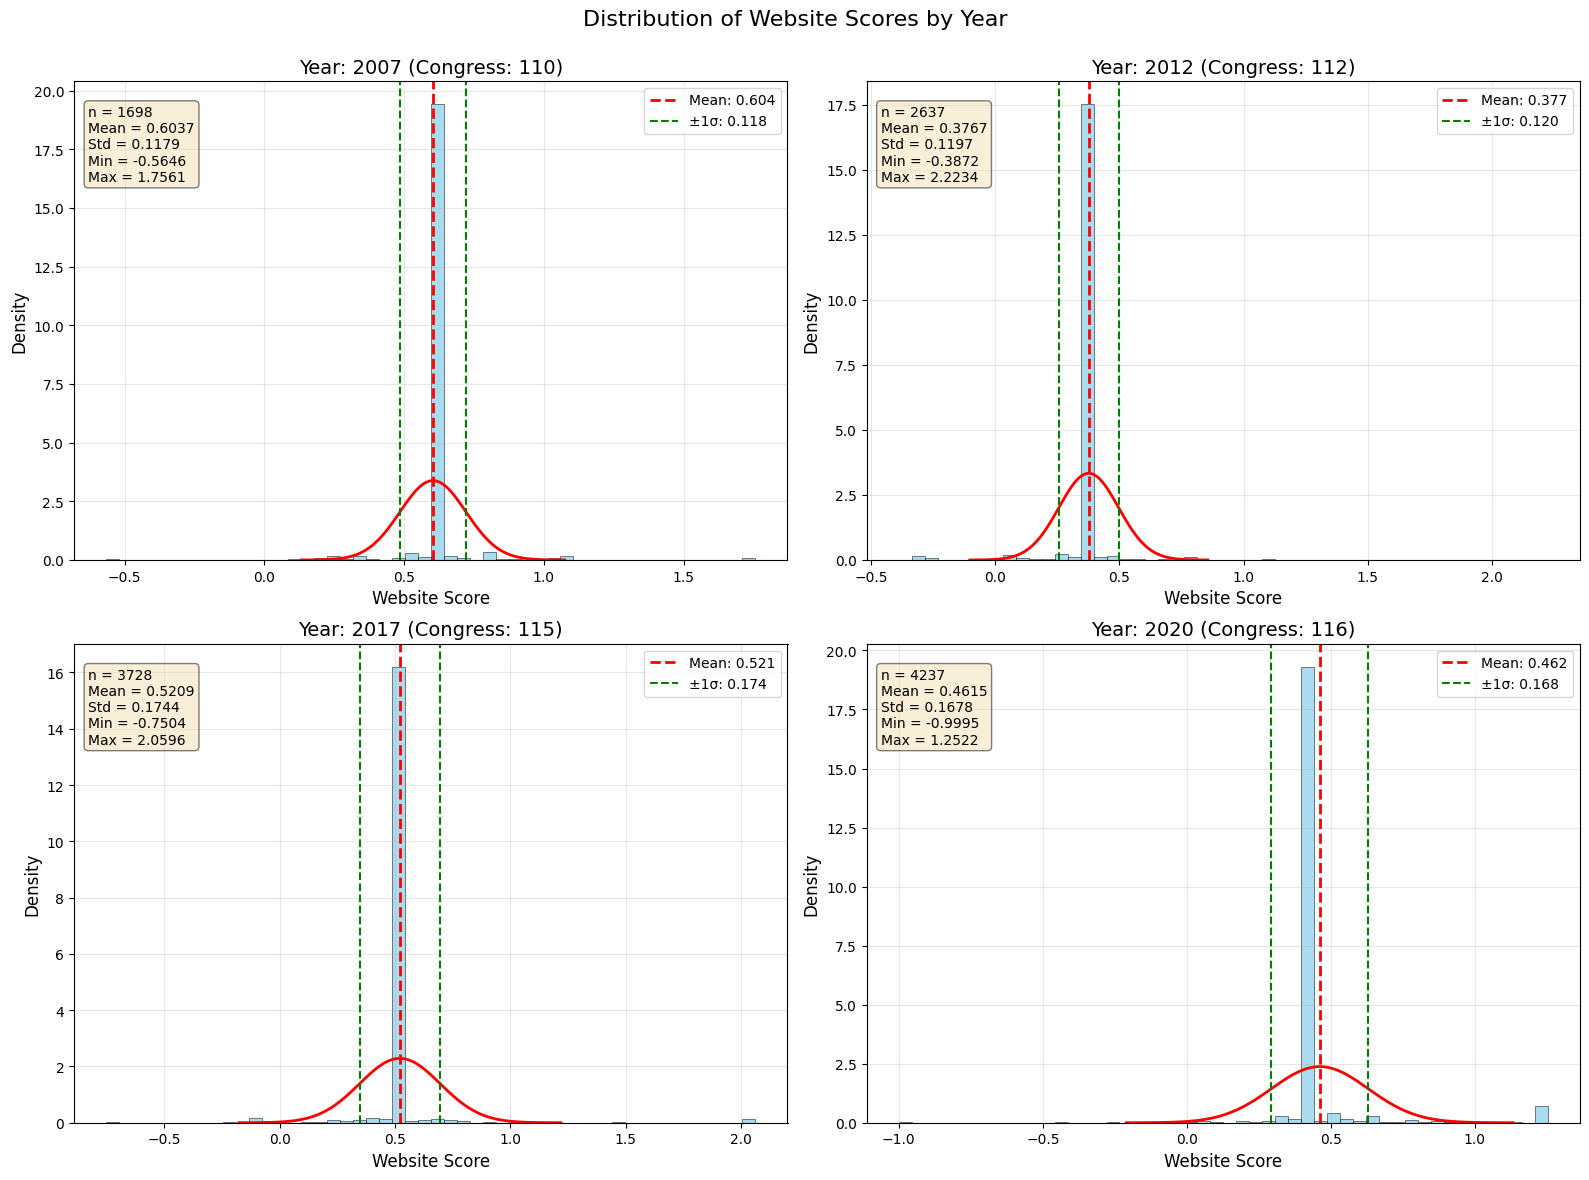

In [12]:
# claude visualization

import numpy as np

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Website Scores by Year', fontsize=16)

# Flatten the axes for easier iteration
axes = axes.flatten()

for i, year_idx in enumerate([0, 5, 10, 13]):  # Sample early, middle, and recent years
    year = list(session_year_map.keys())[year_idx]
    scores = all_website_scores[year_idx]
    print("Number of scores: ", len(scores))
    # scores = scores[:200]
    
    # Calculate statistics
    mean = np.mean(scores)
    std = np.std(scores)
    
    # Plot histogram with density curve
    ax = axes[i]
    n, bins, patches = ax.hist(scores, bins=50, alpha=0.7, density=True, 
                               color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add normal distribution curve
    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    y = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    ax.plot(x, y, 'r-', linewidth=2)
    
    # Add vertical lines for mean and standard deviations
    ax.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.3f}')
    ax.axvline(mean + std, color='green', linestyle='dashed', linewidth=1.5, label=f'±1σ: {std:.3f}')
    ax.axvline(mean - std, color='green', linestyle='dashed', linewidth=1.5)
    
    # Add title and labels
    ax.set_title(f'Year: {year} (Congress: {session_year_map[year]})', fontsize=14)
    ax.set_xlabel('Website Score', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Add text with statistics
    text = f'n = {len(scores)}\nMean = {mean:.4f}\nStd = {std:.4f}\nMin = {min(scores):.4f}\nMax = {max(scores):.4f}'
    ax.text(0.02, 0.95, text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [13]:
import numpy as np
print([np.mean(scores) for scores in all_website_scores])
print([np.std(scores) for scores in all_website_scores])

[0.6036926849022777, 0.5997551264221753, 0.5139985102010288, 0.5153391254158987, 0.38172943937307213, 0.3766574817031422, 0.31498567718388415, 0.3144829956218891, 0.3349240553021116, 0.333623221186185, 0.5208663848964157, 0.5255980146208022, 0.4605461560660144, 0.46153300161695054]
[0.11793829190152472, 0.11275267930382232, 0.17316443643893592, 0.17001486760339657, 0.11789370307973109, 0.11973863312277926, 0.13485384006816453, 0.1327868341174766, 0.10034954004120471, 0.10749749362559483, 0.1744369244322556, 0.18741527178913736, 0.16197810262524753, 0.16784951410744292]


In [14]:
print([np.sum(scores) for scores in all_website_scores])

[1025.0701789640675, 1096.9521262261587, 1005.3810859532123, 1123.439293406659, 942.8717152514881, 993.245779251186, 911.8835354473446, 991.8793681914382, 1131.7083828658351, 1190.0340299711218, 1941.7898828938376, 2044.0506788602997, 1842.6451704201236, 1955.5153278510195]


In [30]:
import matplotlib.pyplot as plt
def plot_data(years, year_scores, year_std_devs, title="All Categories"):
    plt.rcParams.update({'font.size': 5})
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))

    # Plot 1: With confidence intervals
    ax1.plot(years, year_scores, 
            marker='o', color='r', linewidth=2, label='Year Scores')
    ax1.fill_between(years, 
                    [score - 1.96*std for score, std in zip(year_scores, year_std_devs)], 
                    [score + 1.96*std for score, std in zip(year_scores, year_std_devs)], 
                    color='gray', alpha=0.5, label='95% Confidence Interval')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Score')
    ax1.set_title(f'Yearly Scores with Confidence Intervals for {title}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Without confidence intervals
    ax2.plot(years, year_scores, 
            marker='o', color='b', linewidth=2, label='Year Scores')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Score')
    ax2.set_title(f'Yearly Scores for {title}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: With confidence intervals, subtracting the mean
    ax3.plot(years, [score - default_score for (score, default_score) in zip(year_scores, default_scores)], 
            marker='o', color='r', linewidth=2, label='Normalized Year Scores')
    ax3.fill_between(years, 
                    [score - default_score - 1.96*std for score, default_score, std in zip(year_scores, default_scores, year_std_devs)], 
                    [score - default_score + 1.96*std for score, default_score, std in zip(year_scores, default_scores, year_std_devs)], 
                    color='gray', alpha=0.5, label='95% Confidence Interval')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Normalized Score')
    ax3.set_title(f'Yearly Normalized Scores with Confidence Intervals for {title}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Without confidence intervals
    ax4.plot(years, [score - default_score for (score, default_score) in zip(year_scores, default_scores)], 
            marker='o', color='b', linewidth=2, label='Normalized Year Scores')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Normalized Score')
    ax4.set_title(f'Yearly Normalized Scores for {title}')
    ax4.legend()
    ax4.grid(True, alpha=0.3)


    # Add a horizontal line at y=0 for reference in both plots
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    plt.savefig(f"buy_american_graphs/website_scores_{title}.png", dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

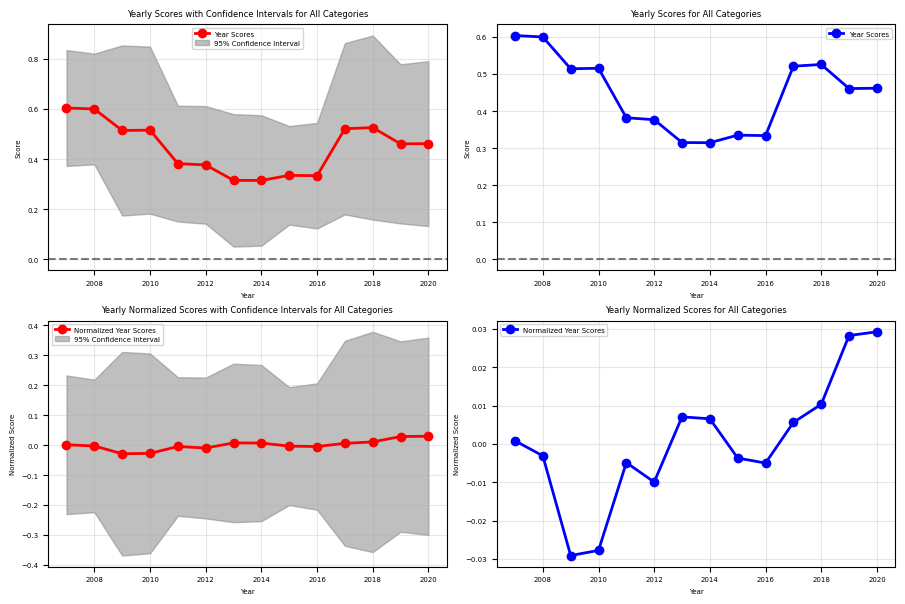

In [32]:
years = list(session_year_map.keys())
year_scores = [np.mean(scores) for scores in all_website_scores]
year_std_devs = [np.std(scores) for scores in all_website_scores]
plot_data(years, year_scores, year_std_devs, title="All Categories")

Important categories with significant counts:  ['Travel, Personal & Leisure TPL', 'Textiles & Clothing Manufacturing TCM', 'Metals & Metal Products MMP', 'Wood, Furniture & Paper Manufacturing WFPM', 'Food & Tobacco Manufacturing FTM', 'Transport Manufacturing TM', 'Miscellaneous Manufacturing MM', 'Industrial, Electric & Electronic Machinery IEEM']


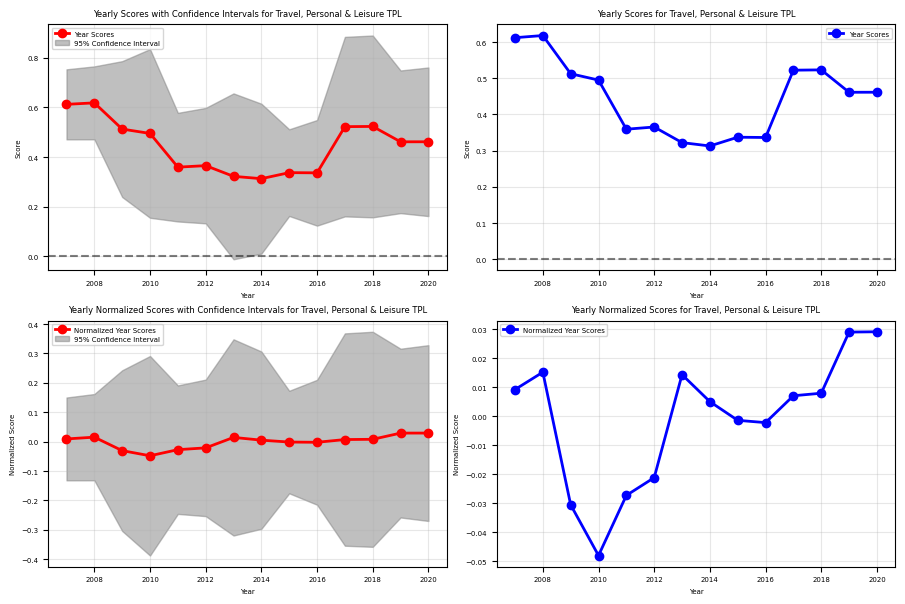

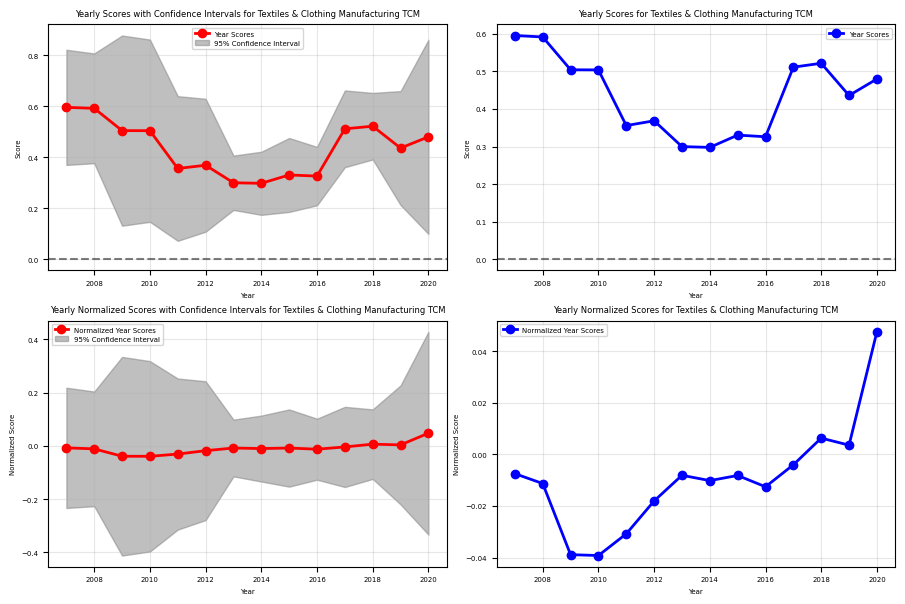

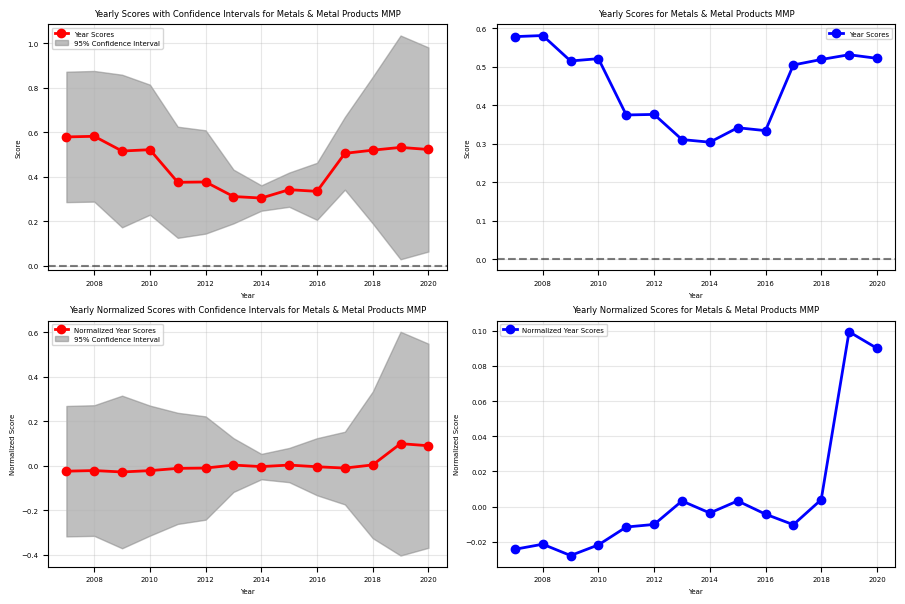

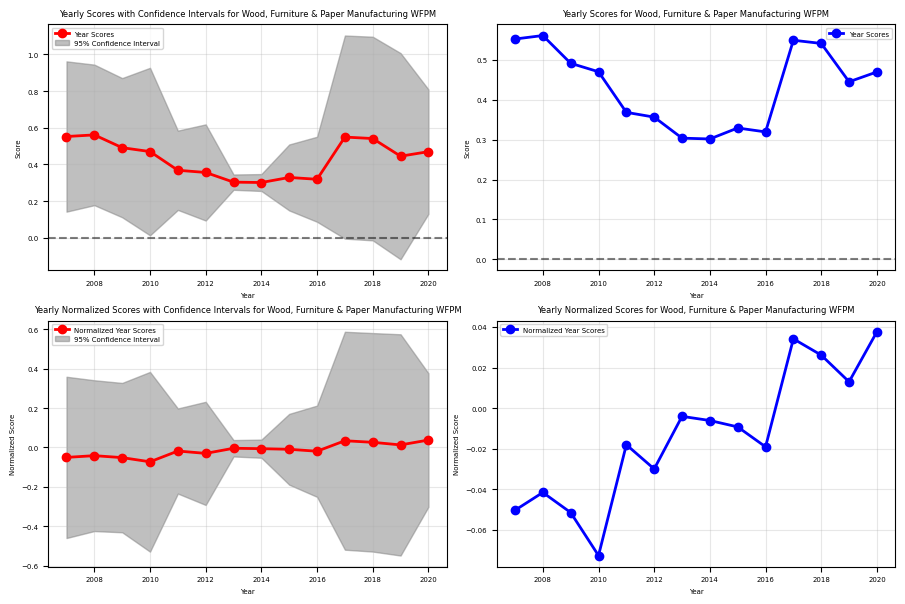

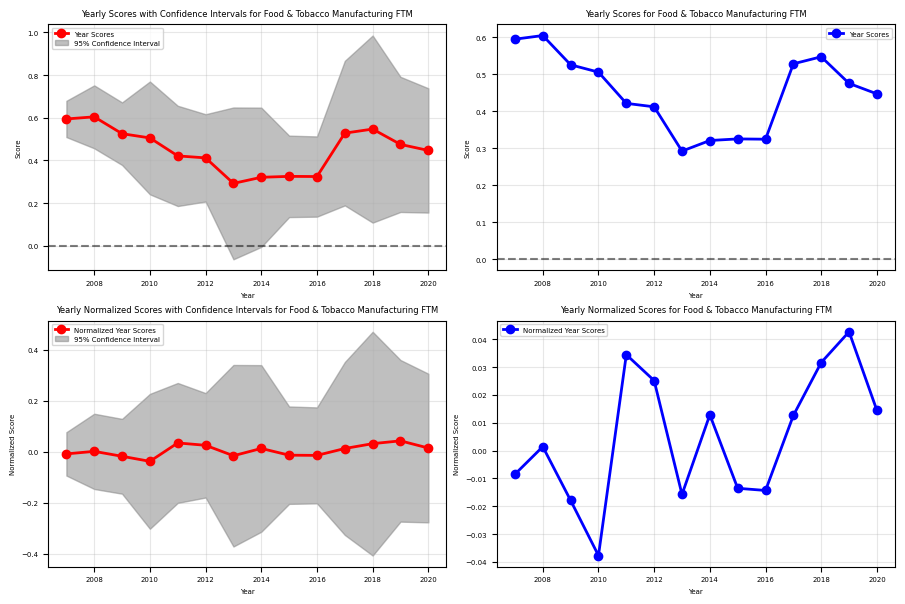

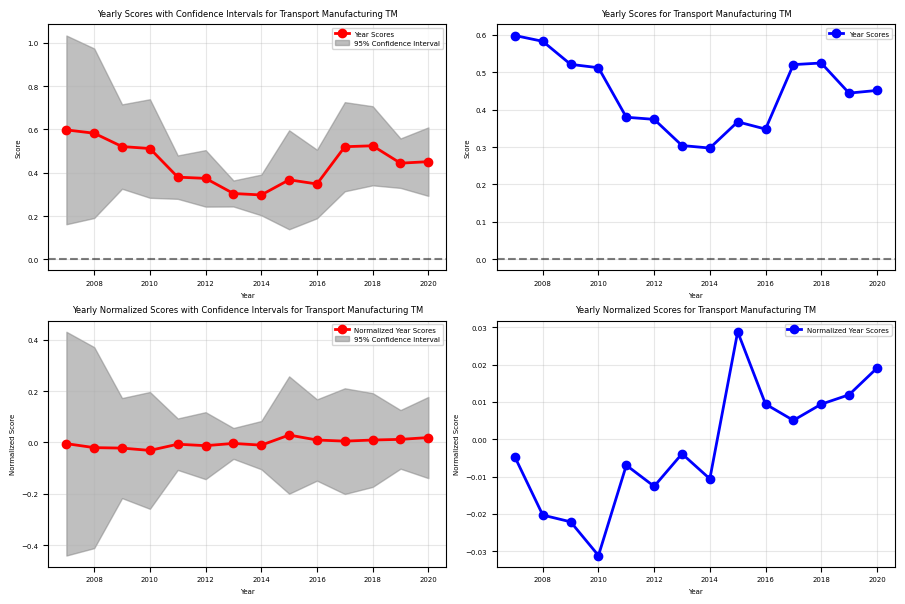

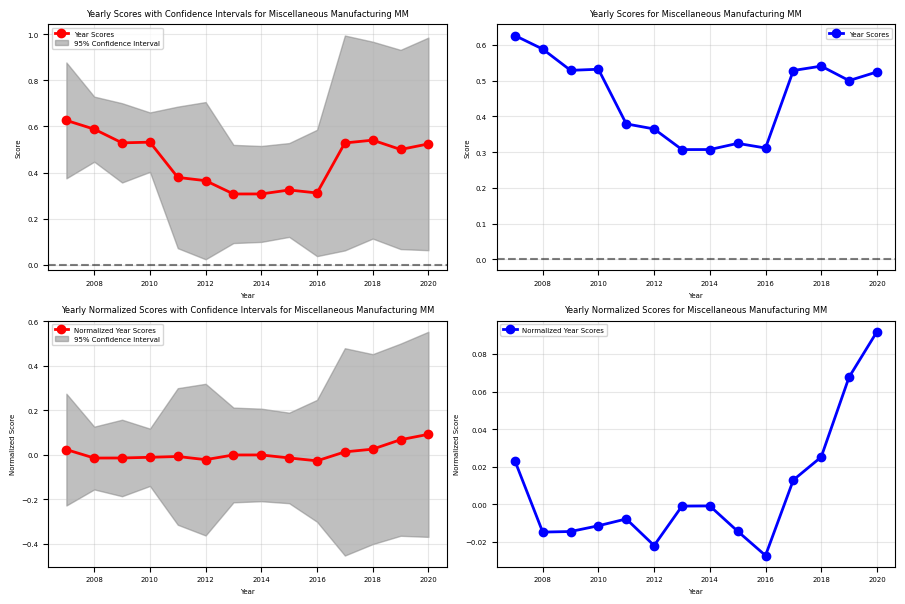

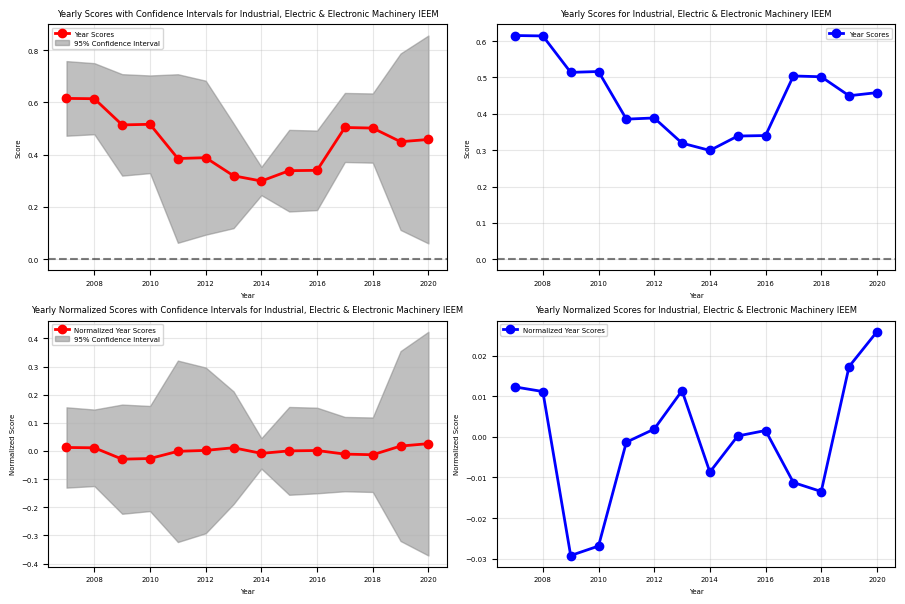

In [33]:
important_categories = [category for category in all_website_scores_by_categories[-1] if len(all_website_scores_by_categories[-1][category]) > 40]
print("Important categories with significant counts: ", important_categories)

for category in important_categories:
    scores = [all_website_scores_by_categories[i][category] for i in range(len(all_website_scores_by_categories))]
    year_scores = [np.mean(category_scores) for category_scores in scores]
    year_std_devs = [np.std(category_scores) for category_scores in scores]
    years = list(session_year_map.keys())
    plot_data(years, year_scores, year_std_devs, title=category)
    